In [ ]:
from google.colab import files
files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/train/Benign/6078.jpg  
  inflating: __MACOSX/archive/train/Benign/._6078.jpg  
  inflating: archive/train/Benign/1717.jpg  
  inflating: __MACOSX/archive/train/Benign/._1717.jpg  
  inflating: archive/train/Benign/283.jpg  
  inflating: __MACOSX/archive/train/Benign/._283.jpg  
  inflating: archive/train/Benign/4647.jpg  
  inflating: __MACOSX/archive/train/Benign/._4647.jpg  
  inflating: archive/train/Benign/3128.jpg  
  inflating: __MACOSX/archive/train/Benign/._3128.jpg  
  inflating: archive/train/Benign/2236.jpg  
  inflating: __MACOSX/archive/train/Benign/._2236.jpg  
  inflating: archive/train/Benign/5559.jpg  
  inflating: __MACOSX/archive/train/Benign/._5559.jpg  
  inflating: archive/train/Benign/6050.jpg  
  inflating: __MACOSX/archive/train/Benign/._6050.jpg  
  inflating: archive/train/Benign/1059.jpg  
  inflating: __MACOSX/archive/train/Benign/._1059.jpg  
  inflating: archive/train/Benign/3896.jpg

In [ ]:
#1-2
#from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class MelanomaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Benign', 'Malignant']
        self.images = []
        self.labels = []

        for idx, label in enumerate(self.classes):
            path = os.path.join(self.root_dir, label)
            images = os.listdir(path)
            for image in images:
                self.images.append(os.path.join(path, image))
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

train_data_dir = '/content/archive/train'
val_data_dir = '/content/archive/test'

train_dataset = MelanomaDataset(root_dir=train_data_dir, transform=train_transforms)
val_dataset = MelanomaDataset(root_dir=val_data_dir, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



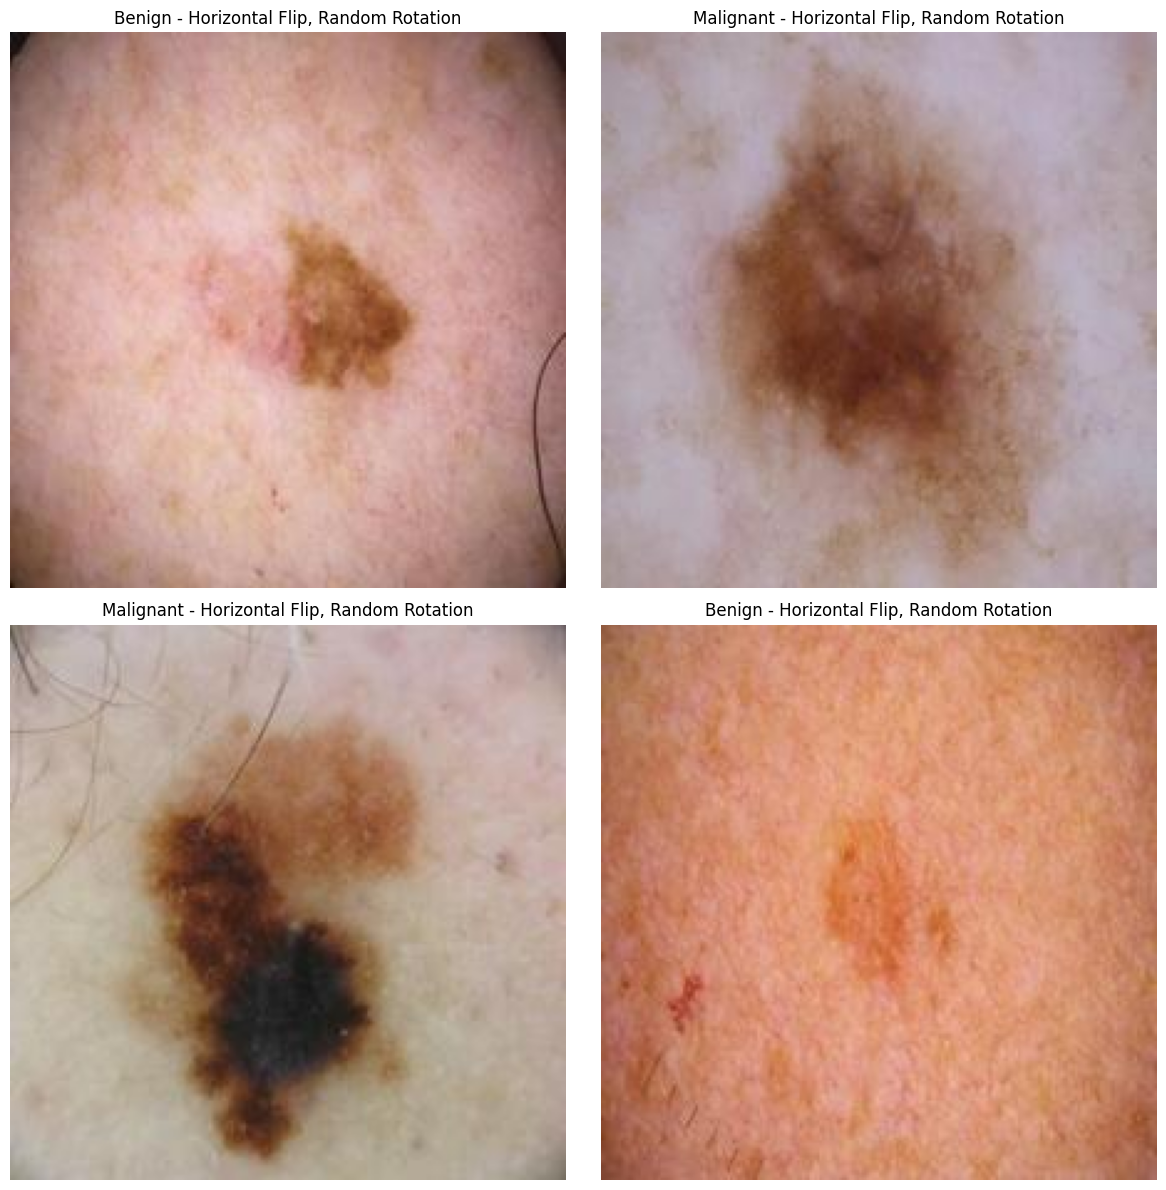

In [ ]:
#3
import matplotlib.pyplot as plt

def show_images(loader, augmentation_types):
    plt.figure(figsize=(12, 12))  # Increase the figure size
    class_names = ['Benign', 'Malignant']  # Define class names manually
    for images, labels in loader:
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            label_name = class_names[labels[i]]  # Map numeric label to string
            plt.title(f'{label_name} - {augmentation_types}')
            plt.axis('off')
        break  # Only show one batch
    plt.tight_layout()  # Adjust the layout
    plt.show()  # Display the plot

# Call the function with the train_loader
show_images(train_loader, "Horizontal Flip, Random Rotation")


In [ ]:
#4-5-6
import torch.nn as nn
import torch.nn.functional as F
import torch

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

# Define the loss function and optimizer outside the class definition
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Print the summary of the model.
from torchsummary import summary
if device == 'cuda':
    summary(model, input_size=(3, 224, 224))
else:
    summary(model.cpu(), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Dropout-10                [-1, 50176]               0
           Linear-11                  [-1, 512]      25,690,624
           Linear-12                    [-1, 2]           1,026
Total params: 25,715,458
Trainable params: 25,715,458
Non-trainable params: 0
-------------------------

Epoch 1, Train Loss: 0.5818, Val Loss: 0.3827, Val Accuracy: 0.8350, Precision: 0.9455, Recall: 0.7110, F1-Score: 0.8116
Epoch 2, Train Loss: 0.3201, Val Loss: 0.2939, Val Accuracy: 0.8985, Precision: 0.8813, Recall: 0.9210, F1-Score: 0.9007
Epoch 3, Train Loss: 0.3067, Val Loss: 0.2966, Val Accuracy: 0.9050, Precision: 0.9201, Recall: 0.8870, F1-Score: 0.9033
Epoch 4, Train Loss: 0.2859, Val Loss: 0.3189, Val Accuracy: 0.8725, Precision: 0.9228, Recall: 0.8130, F1-Score: 0.8644
Epoch 5, Train Loss: 0.2731, Val Loss: 0.2885, Val Accuracy: 0.8880, Precision: 0.8464, Recall: 0.9480, F1-Score: 0.8943


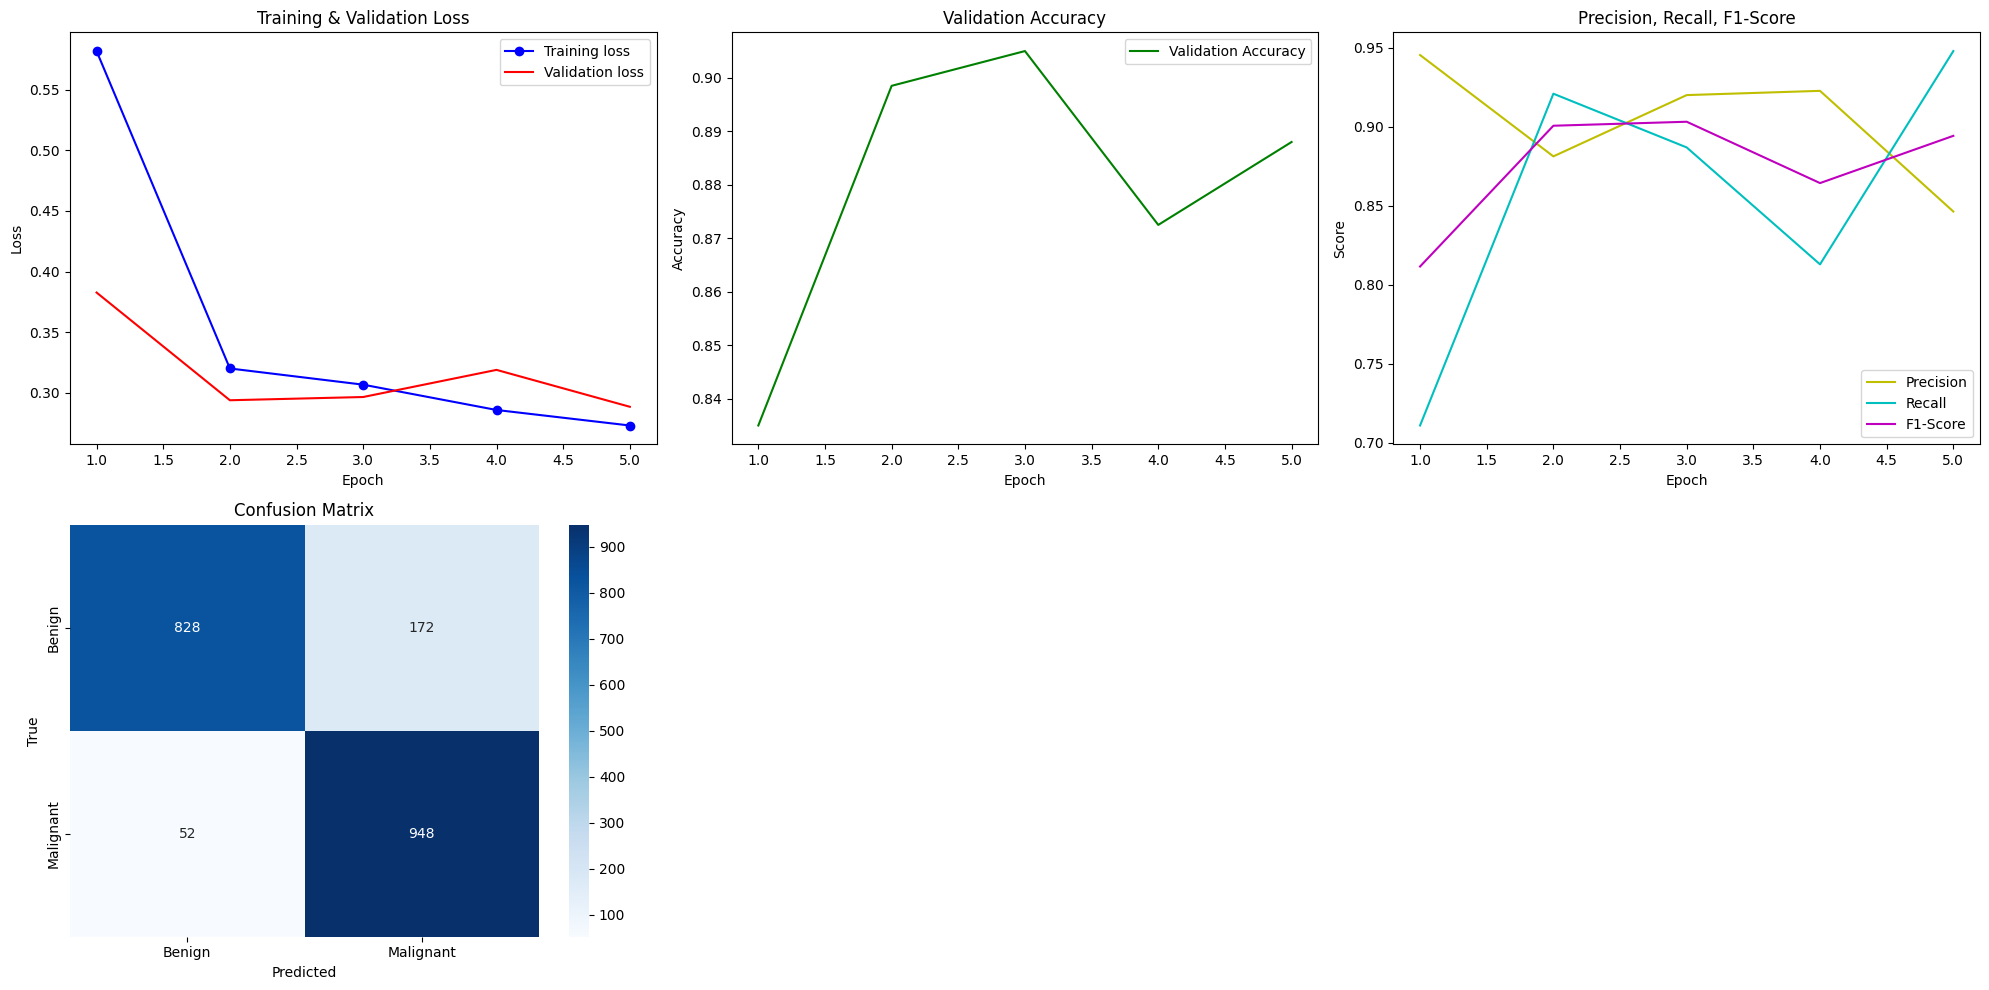

In [ ]:
#7
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    train_losses = []
    val_losses = []
    val_accuracies = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        val_accuracies.append(val_accuracy)

        # Calculate precision, recall, and F1-score
        precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(epochs, precision_list, 'y-', label='Precision')
    plt.plot(epochs, recall_list, 'c-', label='Recall')
    plt.plot(epochs, f1_score_list, 'm-', label='F1-Score')
    plt.title('Precision, Recall, F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.subplot(2, 3, 4)
    conf_mat = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=5, device=device)


Epoch 1/5 - Train Loss: 0.2796, Val Loss: 0.4681, Val Acc: 0.8055
Epoch 2/5 - Train Loss: 0.2628, Val Loss: 0.2828, Val Acc: 0.8925
Epoch 3/5 - Train Loss: 0.2413, Val Loss: 0.2552, Val Acc: 0.8985
Epoch 4/5 - Train Loss: 0.2295, Val Loss: 0.3051, Val Acc: 0.8745
Epoch 5/5 - Train Loss: 0.2201, Val Loss: 0.2610, Val Acc: 0.9010


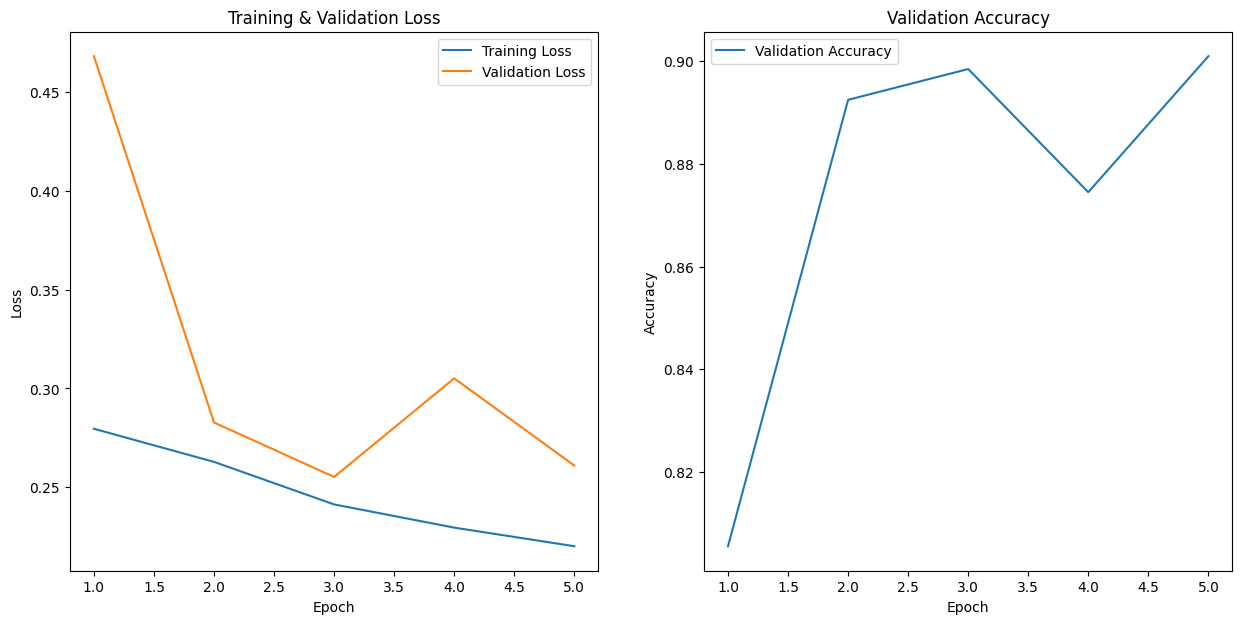

Confusion Matrix:
[[825 175]
 [ 23 977]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.82      0.89      1000
   Malignant       0.85      0.98      0.91      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



In [ ]:
#8-..-13
# combine the training function with both early stopping and a ReduceLROnPlateau learning rate scheduler
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=5, device='cpu'):
    # Initialize the ReduceLROnPlateau scheduler without verbose parameter
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    # Lists to track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early Stopping setup
    best_val_loss = np.inf
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step(val_loss)

    # Plotting training and validation loss and accuracy
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Confusion Matrix and Classification Report
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Execute the training
train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=5, device=device)


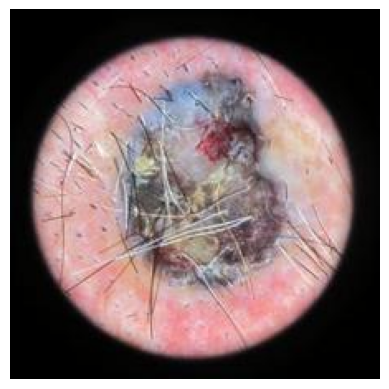

In [ ]:
#14
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, input, output):
            self.gradients = output[0]

        # Find and register hook to the target layer
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.cpu().data.numpy())

        # Create a one-hot encoding for the target class
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1

        # Zero out gradients
        self.model.zero_grad()
        # Backward pass with the target class's one-hot vector
        model_output.backward(gradient=one_hot_output, retain_graph=True)

        # Get the gradients and feature maps from the hooked layer
        gradients = self.gradients.cpu().data.numpy()[0]
        feature_maps = self.feature_maps.cpu().data.numpy()[0]
        # Calculate weights via global average pooling on gradients
        weights = np.mean(gradients, axis=(1, 2))

        # Create a class activation map
        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
        for i, weight in enumerate(weights):
            cam += weight * feature_maps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam / cam.max(), (224, 224))  # Resize to input image size
        return cam


num_classes = 2
model = SimpleCNN(num_classes=num_classes)


model.eval()  # Set model to evaluation mode

# Initialize Grad-CAM for SimpleCNN using the last convolutional layer
grad_cam = GradCAM(model, "conv3")

image_path = '/content/archive/test/Malignant/5616.jpg'  # Update with a real image path
input_image = load_image(image_path)

# Define the class index for 'Malignant'.

target_class = 1  # Replace with the actual class index for 'Malignant'
cam = grad_cam.generate_cam(input_image, target_class)

# Visualize the CAM
original_image = cv2.imread(image_path, 1)
original_image = cv2.resize(original_image, (224, 224))  # Resize to model's input size
show_cam_on_image(original_image, cam)


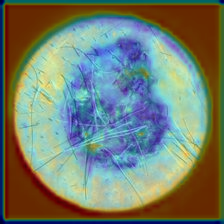

True

In [ ]:
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


# Initialize Grad-CAM for the trained model using the target layer 'conv3' or any other appropriate layer name
grad_cam = GradCAM(model, "conv3")

# Load image
image_path = '/content/archive/test/Malignant/5616.jpg'
input_image = load_image(image_path)

# Define the class index for 'Malignant'.
target_class = 1  # Index for 'Malignant'

# Generate the class activation map
cam = grad_cam.generate_cam(input_image, target_class)

# Read and preprocess the original image
original_image = cv2.imread(image_path, 1)
original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the model's input size

# Create a heatmap from the CAM, making sure to scale the CAM to 0-255 and apply a color map
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.resize(heatmap, (original_image_resized.shape[1], original_image_resized.shape[0]))  # Resize to match original image size

# Overlay the heatmap on the original image
overlayed_image = heatmap * 0.4 + original_image_resized * 0.6  # Blend heatmap and original image
overlayed_image = np.uint8(overlayed_image)  # Convert to uint8 to prepare for displaying

# Show the result using cv2_imshow in Colab or save the image
cv2_imshow(overlayed_image)

# Save the result to a file if needed
cv2.imwrite('/content/cam_on_original.jpg', overlayed_image)


In [ ]:
#15
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import copy


# Data augmentation and normalization for training
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),  # Resize the images to 224x224 to match the ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization parameters for ImageNet
])


train_dataset = ImageFolder(root='/content/archive/train', transform=data_transforms)
val_dataset = ImageFolder(root='/content/archive/test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all the parameters in the model
for param in resnet18.parameters():
    param.requires_grad = False


# For binary classification, out_features = 2
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)  # Adjusting for binary classification

resnet18 = resnet18.to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)



Epoch 1/5, Train Loss: 0.3725, Train Acc: 0.8326, Val Loss: 0.3225, Val Acc: 0.8660
Epoch 2/5, Train Loss: 0.3334, Train Acc: 0.8551, Val Loss: 0.3015, Val Acc: 0.8765
Epoch 3/5, Train Loss: 0.3397, Train Acc: 0.8511, Val Loss: 0.2964, Val Acc: 0.8755
Epoch 4/5, Train Loss: 0.3217, Train Acc: 0.8624, Val Loss: 0.3607, Val Acc: 0.8330
Epoch 5/5, Train Loss: 0.3213, Train Acc: 0.8609, Val Loss: 0.2968, Val Acc: 0.8740


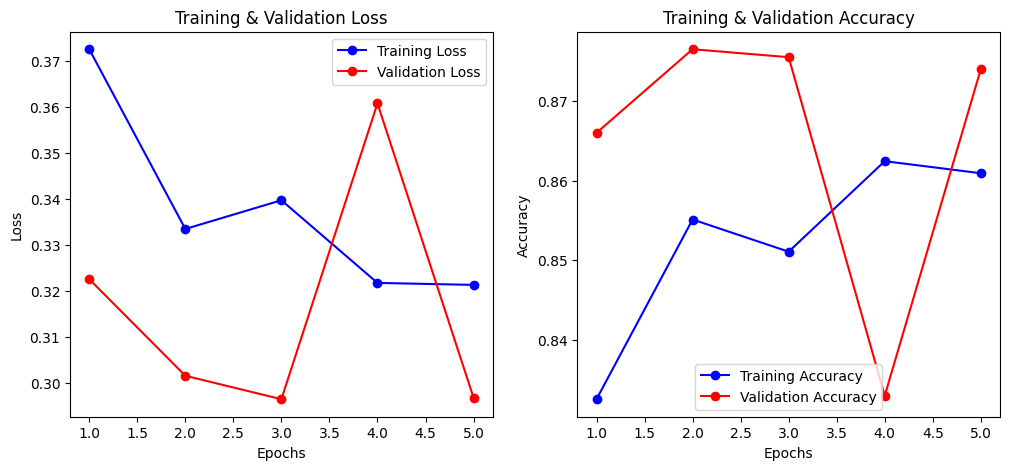

In [ ]:
#16-17
# Function to train the model
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device):
    model.to(device)
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_preds / total_preds
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = correct_preds / total_preds
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, (train_losses, train_accuracies, val_losses, val_accuracies)

# Train the model
num_epochs = 5
resnet18, metrics = train_model(resnet18, train_loader, val_loader, loss_fn, optimizer, num_epochs, device)

# Plot training and validation loss and accuracy
train_losses, train_accuracies, val_losses, val_accuracies = metrics

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'ro-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


17-

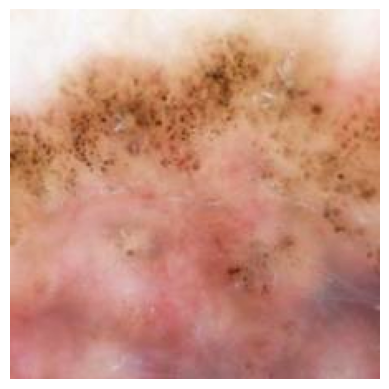

In [ ]:
#18
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import models, transforms
from PIL import Image
import os

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, input, output):
            self.gradients = output[0]

        module = dict(self.model.named_children())[self.target_layer]
        module.register_forward_hook(forward_hook)
        module.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.cpu().data.numpy())

        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        gradients = self.gradients.cpu().data.numpy()[0]
        feature_maps = self.feature_maps.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
        for i, weight in enumerate(weights):
            cam += weight * feature_maps[i]

        cam = np.maximum(cam, 0)
        cam /= np.max(cam)
        return cam

def load_image(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img).unsqueeze(0)
    return img


    ##
def show_cam_on_image(img, mask):
    # Convert grayscale heatmap to colormap for visualization
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    # Resize the heatmap to the size of the image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    # Convert heatmap to float and normalize
    heatmap = np.float32(heatmap) / 255
    # Apply colormap onto the image
    cam = heatmap + np.float32(img)
    # Normalize the result
    cam = cam / np.max(cam)
    # Display image
    plt.imshow(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

##

train_data_dir = '/content/archive/train/Malignant'

image_filename = '/content/archive/test/Malignant/5604.jpg'
img_path = os.path.join(train_data_dir, image_filename)

# Load a pretrained ResNet18 model using the correct weights parameter
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.eval()  # Set model to evaluation mode

# Initialize Grad-CAM and generate CAM for a specific class
grad_cam = GradCAM(model, "layer4")
input_image = load_image(img_path)

target_class = 1  # Replace with the actual class index for 'Malignant'
cam = grad_cam.generate_cam(input_image, target_class)

# Visualize the CAM
original_image = cv2.imread(img_path, 1)
original_image = cv2.resize(original_image, (224, 224))
show_cam_on_image(original_image, cam)


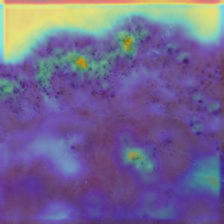

True

In [ ]:
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


# Initialize Grad-CAM for the trained model using the target layer 'conv3' or any other appropriate layer name
grad_cam = GradCAM(model, "conv3")

# Load  image
image_path = '/content/archive/test/Malignant/5604.jpg'
input_image = load_image(image_path)

# Define the class index for 'Malignant'.
target_class = 1

# Generate the class activation map
cam = grad_cam.generate_cam(input_image, target_class)

# Read and preprocess the original image
original_image = cv2.imread(image_path, 1)
original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the model's input size

# Create a heatmap from the CAM, making sure to scale the CAM to 0-255 and apply a color map
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.resize(heatmap, (original_image_resized.shape[1], original_image_resized.shape[0]))  # Resize to match original image size

# Overlay the heatmap on the original image
overlayed_image = heatmap * 0.4 + original_image_resized * 0.6  # Blend heatmap and original image
overlayed_image = np.uint8(overlayed_image)  # Convert to uint8 to prepare for displaying

# Show the result using cv2_imshow in Colab or save the image
cv2_imshow(overlayed_image)

# Save the result to a file if needed
cv2.imwrite('/content/cam_on_original.jpg', overlayed_image)
